# confident_prediction_for_time_serial_indoor_temp_Keras

In [1]:
import os
import sys
import time
import optparse
import configparser
#import pyodbc
import pandas as pd
import numpy as np
import datetime
#import holidays
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Input, concatenate, Lambda, Reshape, BatchNormalization, Dropout
from keras.models import Sequential, Model

import matplotlib
import numpy as np
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
%matplotlib inline  

C:\Users\zd2212\AppData\Local\conda\conda\envs\tflatest\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Hyperparameter

In [9]:
T_out = 4 * 24
input_dim = 7
batch_size = 1 * 24 * 4 * 7 * 2
decoder_epochs = 1
predictnet_epochs = 1
baseline_lstm_epochs = 50

is_load_decoder_best_weight = False
is_load_predictnet_best_weight = False
is_load_baseline_lstm_best_weight = True
is_train_decoder = True
is_train_predictnet= True
is_train_baseline_lstm = False

if(is_load_decoder_best_weight is True):
    is_load_decoder_best_weight = False
    is_train_decoder = False
    print('Since load the weight of predictnet is True, there is not need to load/train decoder')

decoder_weight_filepath="./weights/weights_decoder.best.hdf5"
predictnet_weight_filepath="./weights/weights_predictnet.best.hdf5"
baseline_lstm_filepath="./weights/weights_baseline_lstm.best.hdf5"

### DB Server Data Collection

> @TODO

### Local Data Collection

In [3]:
def time_process(date):
    time=datetime.datetime.strptime(date,'%Y-%m-%d %H:%M:%S.0000000')
    return datetime.datetime(time.year,time.month,time.day,time.hour)

def weather_data_feature_selected_and_serialize(df_weather):
    cols=['TempM','DewPointM','Humidity','WindSpeedM' ,'PressureM']
    for col in cols:
        df_weather = df_weather.loc[~(df_weather[col] == 'N/A')]
        df_weather = df_weather.loc[~(df_weather[col] == -9999)]
    date_trans=lambda date:datetime.datetime(date.year, date.month, date.day, date.hour)
    df_weather['time']=df_weather['Date'].apply(date_trans)
    df_weather = df_weather.dropna()
    df_weather.drop('Date',axis=1,inplace=True)
    result = df_weather.groupby('time').apply(np.mean)
    return result

def weather_data_interpolation(df_weather):
    interpolate_sample = df_weather.resample('15Min').asfreq()
    df_weather_interpolated = interpolate_sample.interpolate(method='time')
    return df_weather_interpolated

def space_temp_data_feature_selected_and_serialize(df_space):
    cols=['Date','temp']
    df_space = df_space[cols]
    df_space = df_space.dropna()
    date_trans=lambda date:datetime.datetime(date.year, date.month, date.day, date.hour, date.minute)
    df_space['time'] = df_space['Date'].apply(date_trans)
    df_space.drop('Date', axis=1, inplace=True)
    result = df_space.groupby('time').apply(np.mean)
    return result

def space_temp_extreme_data_clean_up(df_space, bad_values, verbose):
    df_space_cleaned = df_space.copy()
    
    clean_up_temp = []
    
    for bad_value in bad_values:
        for i in df_space.loc[df_space['temp'] == bad_value].index:
            clean_up_temp.append((df_space_cleaned.loc[i]))
            df_space_cleaned = df_space_cleaned.drop(i)
    
    if(verbose == True):
        show_interpolation_data_range(clean_up_temp)
    
    return df_space_cleaned

def space_temp_data_interpolation(df_space):
    interpolate_sample = df_space.resample('15Min').asfreq()
    df_space_interpolated = interpolate_sample.interpolate(method='time')
    return df_space_interpolated

def occupancy_data_serialize(df_occupancy):
    cols=['TIMESTAMP', 'VALUE']
    df_occupancy = df_occupancy[cols]
    df_occupancy = df_occupancy.dropna()
    date_trans=lambda date:datetime.datetime(date.year, date.month, date.day, date.hour, date.minute)
    df_occupancy['time'] = df_occupancy['TIMESTAMP'].apply(date_trans)
    df_occupancy['occupancy'] = df_occupancy['VALUE']
    df_occupancy.drop('TIMESTAMP', axis=1, inplace=True)
    df_occupancy.drop('VALUE', axis=1, inplace=True)
    result = df_occupancy.groupby('time').apply(np.mean)
    return df_occupancy

def occupancy_data_remove_duplicate(df_occupancy):
    df_occupancy = df_occupancy.copy()
    df_occupancy = df_occupancy[['TIMESTAMP', 'VALUE']]
    df_occupancy['date']=pd.to_datetime(df_occupancy['TIMESTAMP'])
    df_occupancy['occupancy']=df_occupancy['VALUE']
    df_occupancy.drop('TIMESTAMP', axis=1, inplace=True)
    df_occupancy.drop('VALUE', axis=1, inplace=True)
    df_occupancy = df_occupancy.set_index('date')
    df_occupancy_remove_duplicate = df_occupancy[~df_occupancy.index.duplicated()]
    return df_occupancy_remove_duplicate
    
def occupancy_data_interpolation(df_occupancy):
    for col in df_occupancy:
        df_occupancy[col] = pd.to_numeric(df_occupancy[col], errors='coerce')
    interpolate_sample = df_occupancy.resample('5Min').asfreq()
    df_occupancy_interpolated = interpolate_sample.interpolate(method='time')
    return df_occupancy_interpolated

def occupancy_data_duplicate_data(df_occupancy, year=1):
    df_occupancy = df_occupancy.copy()
    df_occupancy = df_occupancy.reset_index()
    year_index = 12 * 24 * 365 * year
    df_temp = pd.DataFrame(columns=['date','occupancy'])
    for i in range(year_index):
        length = len(df_occupancy)
        new_date = df_occupancy.loc[i, 'date'] -  pd.DateOffset(years=1)
        new_occupancy = df_occupancy.loc[i, 'occupancy']
        df_temp = df_temp.append({'date': new_date, 'occupancy': new_occupancy}, ignore_index=True)
        
    df_occupancy_duplicated = pd.concat([df_occupancy, df_temp]).set_index('date').sort_index() 
    return df_occupancy_duplicated

def data_resampling(dataframe, resample_rate=1):
    # resample every 1 row, i.e., do nothing
    if(resample_rate == 1):
        return dataframe
    else:
        return dataframe.iloc[::resample_rate, :]

# --------------- Preprocessing Delimiter ---------------------- #
def weather_data_preprocess(df_weather, bad_values=[0, 162.8, 250]):
    df_weather_serial = weather_data_feature_selected_and_serialize(df_weather)
    df_weather_serial_interpolated = weather_data_interpolation(df_weather_serial)    
    return df_weather_serial_interpolated
    
def space_temp_data_preprocess(df_space, bad_values=[0, 162.8, 250], verbose=False):
    df_space_serial = space_temp_data_feature_selected_and_serialize(df_space)
    df_space_serial_cleaned = space_temp_extreme_data_clean_up(df_space_serial, bad_values, verbose)
    df_space_serial_interpolated = space_temp_data_interpolation(df_space_serial_cleaned)
    
    return df_space_serial_interpolated

def occupancy_data_preprocess(df_occupancy, verbose=False):
    df_occupancy_remove_duplicate = occupancy_data_remove_duplicate(df_occupancy)
    df_occupancy_interpolated = occupancy_data_interpolation(df_occupancy_remove_duplicate)
    df_occupancy_preprocessed = occupancy_data_duplicate_data(df_occupancy_interpolated)
    return df_occupancy_preprocessed

# In case people want to check the data after preprocessing
def write_data_to_excel(dataframe, filename):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')

    # Convert the dataframe to an XlsxWriter Excel object.
    dataframe.to_excel(writer, sheet_name='Sheet1')

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    
# cleanning data printer
def show_interpolation_data_range(clean_up_list):
    bad_data_counter = {}
    
    for i, row in enumerate(clean_up_list):
        print(  'Temp: %s   '%(row['temp']), 'Date:', row.name)
        if(str(row['temp']) not in bad_data_counter):
            bad_data_counter[str(row['temp'])] = 1
        else:
            bad_data_counter[str(row['temp'])] += 1
    
    # Print counter
    for key, value in bad_data_counter.items():
        print('Clean up %s bad data(%s)' %(value, key))


In [4]:
# read datas
temp_space = pd.read_excel('./datasets/88688_gap_15min_space_temp_f18_csw.xlsx')
temp_weather = pd.read_excel('./datasets/68364_gap_1h_weather_temp.xlsx')
occupancy = pd.read_excel('./datasets/171553_gap_5min_occupancy.xlsx')

# Preprocessing
df_weather=pd.DataFrame(np.array(temp_weather),columns=['Run_DateTime','Date','UTC_Date','TempA','TempM',
                                                        'DewPointA','DewPointM' ,'Humidity' ,'WindSpeedA',
                                                       'WindSpeedM' ,'WindGustA' ,'WindGustM' ,'WindDir',
                                                       'VisibilityA' ,'VisibilityM' ,'PressureA' ,'PressureM',
                                                       'WindChillA' ,'WindChillM' ,'HeatIndexA' ,'HeatIndexM',
                                                       'PrecipA' ,'PrecipM' ,'Condition' ,'Fog' ,'Rain',
                                                       'Snow' ,'Hail' ,'Thunder','Tornado' ,'ID'])
df_weather = df_weather[['Date','TempM','DewPointM','Humidity','WindSpeedM' ,'PressureM']]

df_space = pd.DataFrame(np.array(temp_space),columns=['ID','zone','floor','quadrant','eq_no','Date','temp'])


df_occupancy = pd.DataFrame(np.array(occupancy), columns=['ID', 'ZONE', 'FLOOR', 'QUADRANT', 'EQUIPMENT_NO', 'TIMESTAMP', 'VALUE'])


df_weather_processed = weather_data_preprocess(df_weather)
df_space_processed = space_temp_data_preprocess(df_space, bad_values=[0, 162.8, 250], verbose=False)
df_occupancy_processed = occupancy_data_preprocess(df_occupancy, verbose=True)

# Merge data
df = pd.merge(df_weather_processed, df_space_processed, left_index=True, right_index=True)
df = pd.merge(df, df_occupancy_processed, left_index=True, right_index=True)
df.head()

,TempM,DewPointM,Humidity,WindSpeedM,PressureM,temp,occupancy
2012-06-09 08:45:00,20.15,11.550,57.75,5.55,1013.575,74.528259,6.0
2012-06-09 09:00:00,20.00,11.700,59.00,7.40,1013.700,74.377136,13.0
2012-06-09 09:15:00,20.15,11.425,57.50,5.55,1013.625,74.226013,14.0
2012-06-09 09:30:00,20.30,11.150,56.00,3.70,1013.550,73.999268,18.0
2012-06-09 09:45:00,20.45,10.875,54.50,1.85,1013.475,73.848145,19.0


In [5]:
scaler = StandardScaler()

def get_batch(df, batch_size=128, T=16, T_out = 24*4, input_dim=6, step=1, output_dim = 1, train=False):
    
    t = 0
    X_batch = np.empty(shape=[batch_size, T, input_dim])
    y_batch = np.empty(shape=[batch_size, T])
    labels = np.empty(shape=[batch_size, T_out, output_dim])
    #time_batch = np.empty(shape=[batch_size, T], dtype='datetime64')
    time_batch = np.array([])
    time_stamp = df.index.tolist()
    X_all = scaler.fit_transform(df.values)
    Y_all = df["temp"].values
    Y_all = np.reshape(Y_all,(np.prod(Y_all.shape),1))
    Y_all = scaler.fit_transform(Y_all)
    for i in range(batch_size):
        X_batch[i,:,:] = X_all[t:t+T,:]
        y_batch[i,:] = Y_all[t:t+T,0]
        l = Y_all[t+T:t+T+T_out,0]
        labels[i,:,:] = l.reshape((int(np.prod(l.shape)),1))
        time_batch = np.append(time_batch, time_stamp[t+T])
        t += step     
    
    ## shuffle in train, not in test
    if train:
        index = list(range(batch_size))
        np.random.shuffle(index)
        X_batch = X_batch[index]
        y_batch = y_batch[index]
        labels = labels[index]
        time_batch = time_batch[index]

    return X_batch, y_batch, labels, time_batch

In [6]:
x, y, labels, time_train = get_batch(df, batch_size=int(T_out * int(len(df)/T_out)) - 8 * 24 * 4, T=7 * T_out, T_out=T_out, input_dim=input_dim)
train_samples = int(np.floor(x.shape[0] * 0.8))

In [7]:
print(x.shape)
print(y.shape)
print(labels.shape)
print(time_train.shape)

X_train = x[:train_samples,:,:]
X2_train = X_train[:,-T_out:,:]
Y_train = labels[:train_samples]

X_test = x[train_samples:,:,:]
X2_test = X_test[:,-T_out:,:]
Y_test = labels[train_samples:]

#Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],1))
#Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],1))
print(X_train.shape)
print(Y_train.shape)
print(X2_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X2_test.shape)

(92352, 672, 7)
(92352, 672)
(92352, 96, 1)
(92352,)
(73881, 672, 7)
(73881, 96, 1)
(73881, 96, 7)
(18471, 672, 7)
(18471, 96, 1)
(18471, 96, 7)


In [11]:
# Define an input sequence and process it.

encoder_inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
decoder_inputs = Input(shape=(X2_train.shape[1], X_train.shape[2]))
encoder = LSTM(64, return_sequences = True, dropout=0.2, recurrent_dropout=0.2)(encoder_inputs)
encoder_output, state_h, state_c = LSTM(64, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)(encoder)

# We discard `encoder_outputs` and only keep the states.
encoder_states = concatenate([state_h, state_c])

#pred_latent = 64
dense_prediction = Dense(Y_train.shape[1] * 32, activation = 'relu')(encoder_states)
dense_prediction = Dense(Y_train.shape[1] * 16, activation = 'relu')(dense_prediction)
dense_prediction = Dense(Y_train.shape[1] * 8, activation = 'relu')(dense_prediction)
dense_prediction = Dense(Y_train.shape[1] * 4, activation = 'relu')(dense_prediction)
dense_prediction = Dense(Y_train.shape[1] * 2, activation = 'relu')(dense_prediction)
dense_prediction = Dense(Y_train.shape[1] * Y_train.shape[2], activation = 'linear')(dense_prediction)
dense_prediction = Dropout(0.2)(dense_prediction, training=True)

dense_prediction = Reshape((Y_train.shape[1], Y_train.shape[2]), name = 'prediction_output')(dense_prediction)

decoder_lstm,_,_ = LSTM(64, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)(decoder_inputs, initial_state = [state_h, state_c])
decoder_lstm,_,_ = LSTM(64, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)(decoder_lstm)
dense_decoder = Dense(Y_train.shape[2], activation = 'linear', name = 'decoder_output')(decoder_lstm)

#Dense(n_embedding)(encoder_states)

model = Model([encoder_inputs, decoder_inputs], [dense_decoder, dense_prediction])
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 672, 7)       0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 672, 64)      18432       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 672, 64), (N 33024       lstm_5[0][0]                     
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 128)          0           lstm_6[0][1]                     
                                                                 lstm_6[0][2]                     
__________

### LSTM Decoder - Model Training

In [12]:
# Run training
model.compile(optimizer='adam',
              loss={'decoder_output': 'mse', 'prediction_output': 'mse'},
              loss_weights={'decoder_output': 1.0, 'prediction_output': 0.0})

if(is_load_decoder_best_weight is True):
    model.load_weights(decoder_weight_filepath)

if(is_train_decoder is True):
    checkpoint = ModelCheckpoint(decoder_weight_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    
    print('Starting training...')
    model.fit([X_train, X2_train], [Y_train, Y_train],
              batch_size=batch_size,
              epochs=decoder_epochs,
              validation_split=0.2,
              callbacks=callbacks_list)

Starting training...
Train on 59104 samples, validate on 14777 samples
Epoch 1/1
59104/59104 [==============================] - 367s 6ms/step - loss: 0.6709 - decoder_output_loss: 0.6709 - prediction_output_loss: 1.0512 - val_loss: 0.4895 - val_decoder_output_loss: 0.4895 - val_prediction_output_loss: 1.0659

Epoch 00001: val_loss improved from inf to 0.48945, saving model to ./weights/weights_decoder.best.hdf5


C:\Users\zd2212\AppData\Local\conda\conda\envs\tflatest\lib\site-packages\keras\engine\network.py:888: UserWarning: Layer lstm_7 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_6/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_6/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [25]:
X_test_p = X_test[:,:,:]
X2_test_p = X2_test[:,:,:]
Y_test_p = Y_test[:,:,:]

time_1 = time.time()
Y_preds = model.predict([X_test_p, X2_test_p])
time_2 = time.time()

print(time_2 - time_1)

Y_preds_decoder = Y_preds[0]
Y_preds_forecast = Y_preds[1]

Y_preds_forecast = scaler.inverse_transform(Y_preds_forecast)
Y_preds_decoder = scaler.inverse_transform(Y_preds_decoder)
Y_test_p = scaler.inverse_transform(Y_test_p)

1564.6958837509155


In [24]:
test_1 = Y_preds

In [26]:
test_2 = Y_preds

In [27]:
for i in range(len(test_1)):
    print(test_1[i] - test_2[i])

[[[ 3.3889437e-01]
  [ 5.2664673e-01]
  [ 5.9944916e-01]
  ...
  [-1.1920929e-07]
  [ 0.0000000e+00]
  [ 1.1920929e-07]]

 [[ 3.4886059e-01]
  [ 5.4458922e-01]
  [ 6.2249982e-01]
  ...
  [ 0.0000000e+00]
  [ 1.1920929e-07]
  [ 0.0000000e+00]]

 [[ 3.5425481e-01]
  [ 5.5564785e-01]
  [ 6.3841486e-01]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]

 ...

 [[-1.7435156e-01]
  [-2.5072876e-01]
  [-2.6561704e-01]
  ...
  [ 1.7881393e-07]
  [ 1.1920929e-07]
  [ 5.9604645e-08]]

 [[-1.7416427e-01]
  [-2.5029522e-01]
  [-2.6501212e-01]
  ...
  [ 2.3841858e-07]
  [ 5.9604645e-08]
  [ 1.7881393e-07]]

 [[-1.7370744e-01]
  [-2.4934646e-01]
  [-2.6379836e-01]
  ...
  [ 5.9604645e-08]
  [ 1.7881393e-07]
  [ 1.7881393e-07]]]
[[[-0.68174493]
  [-0.66734016]
  [ 0.        ]
  ...
  [-0.5739692 ]
  [-0.45014942]
  [-0.04044574]]

 [[-0.75567687]
  [-0.66998   ]
  [-0.7791811 ]
  ...
  [-0.5773077 ]
  [-0.05123846]
  [-0.5269196 ]]

 [[-0.7625273 ]
  [-0.6860349 ]
  [ 0.0326424 ]
  ...


### LSTM Decoder - Next Step Prediction

LSTM Decoder RMSE :  1.162550656109182


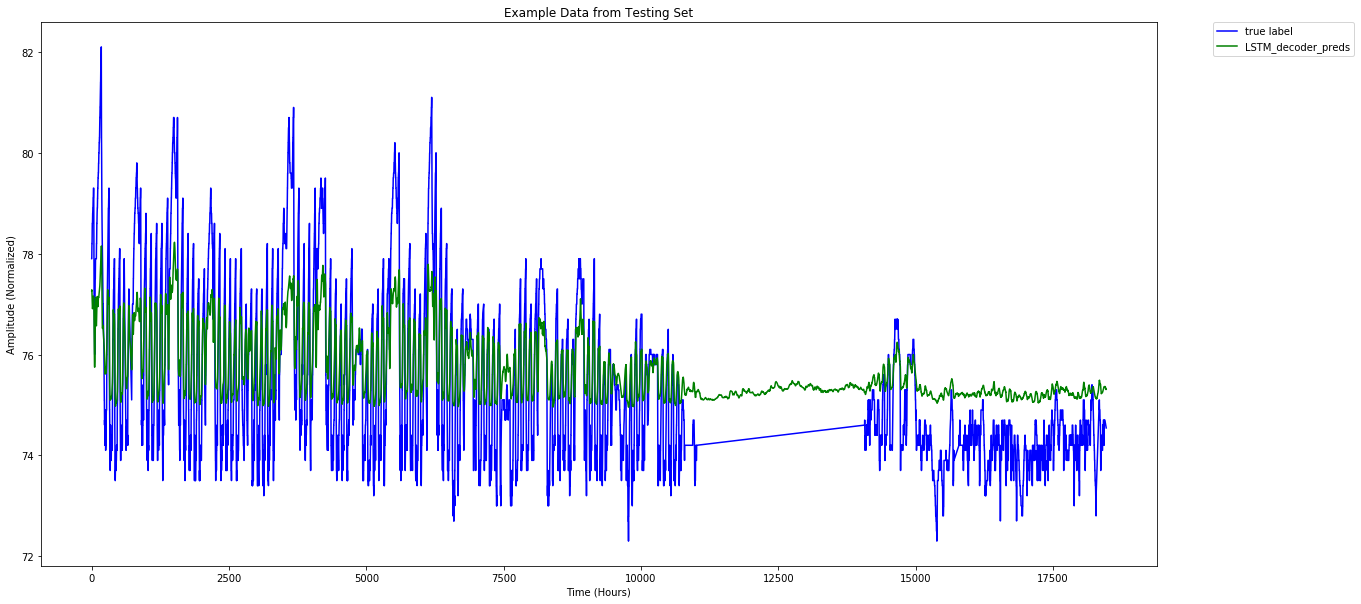

In [15]:
plt.figure(figsize=(20,10))
plt.title('Example Data from Testing Set')

plt.plot(Y_test_p[:, 0, :], 'blue', label="true label")
#plt.plot(Y_preds_forecast[:, 0, :], 'red', label="PredictNet_preds")
plt.plot(Y_preds_decoder[:, 0, :], 'green', label="LSTM_decoder_preds")
plt.xlabel('Time (Hours)')
plt.ylabel('Amplitude (Normalized)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#print("PredictNet RMSE : ", np.sum((Y_preds_forecast[:, 0, :] - Y_test_p[:, 0, :]) ** 2) / len(Y_test_p[:, 0, :]))
print("LSTM Decoder RMSE : ", np.sum((Y_preds_decoder[:, 0, :] - Y_test_p[:, 0, :]) ** 2) / len(Y_test_p[:, 0, :]))

### LSTM Decoder - Next 24 Hours Prediction

LSTM Decoder RMSE :  1.3905845750745982


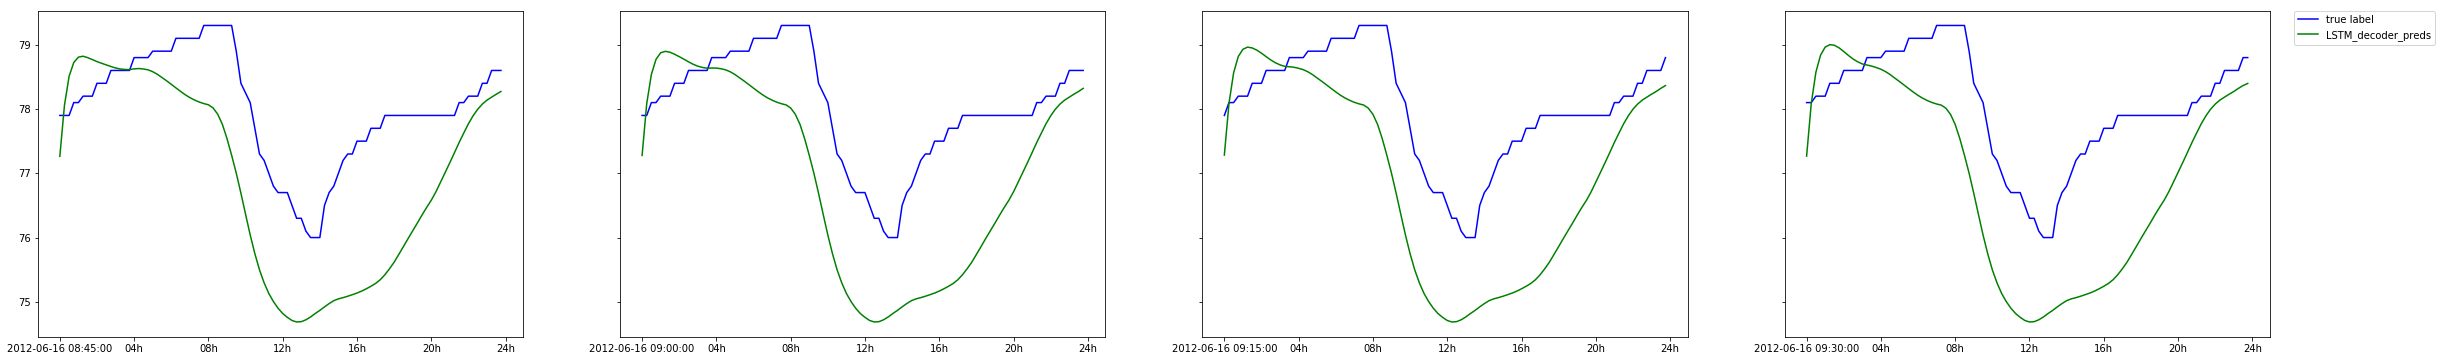

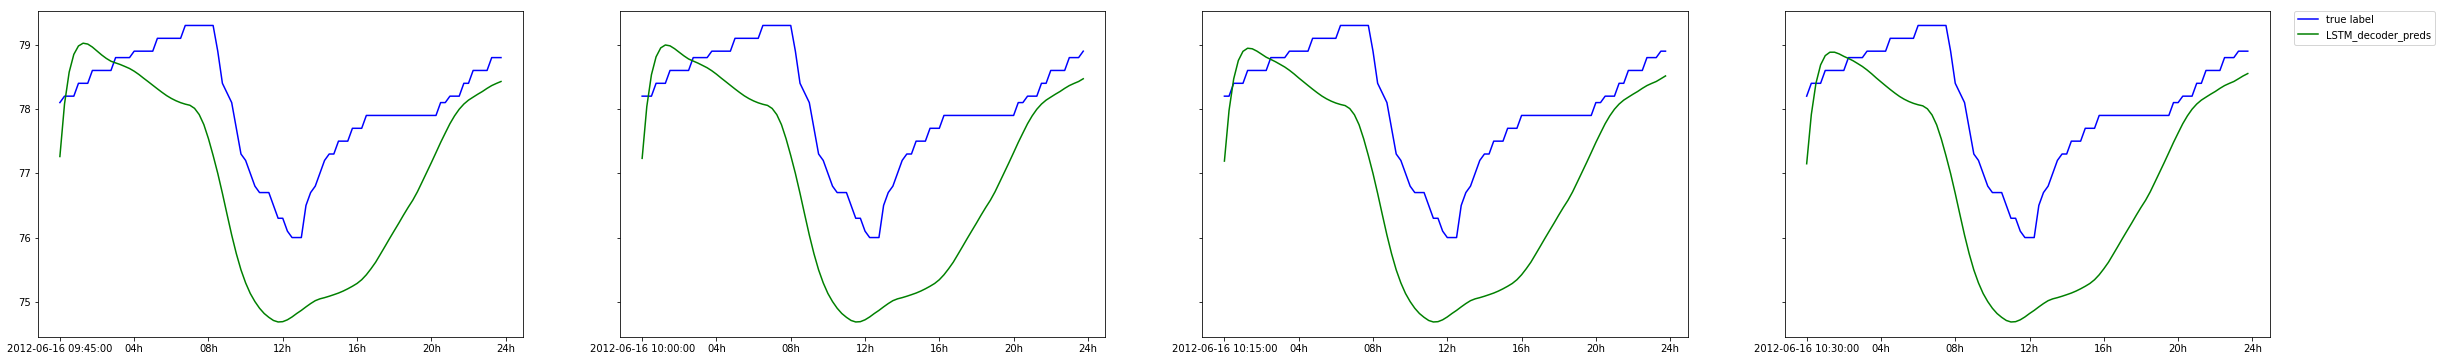

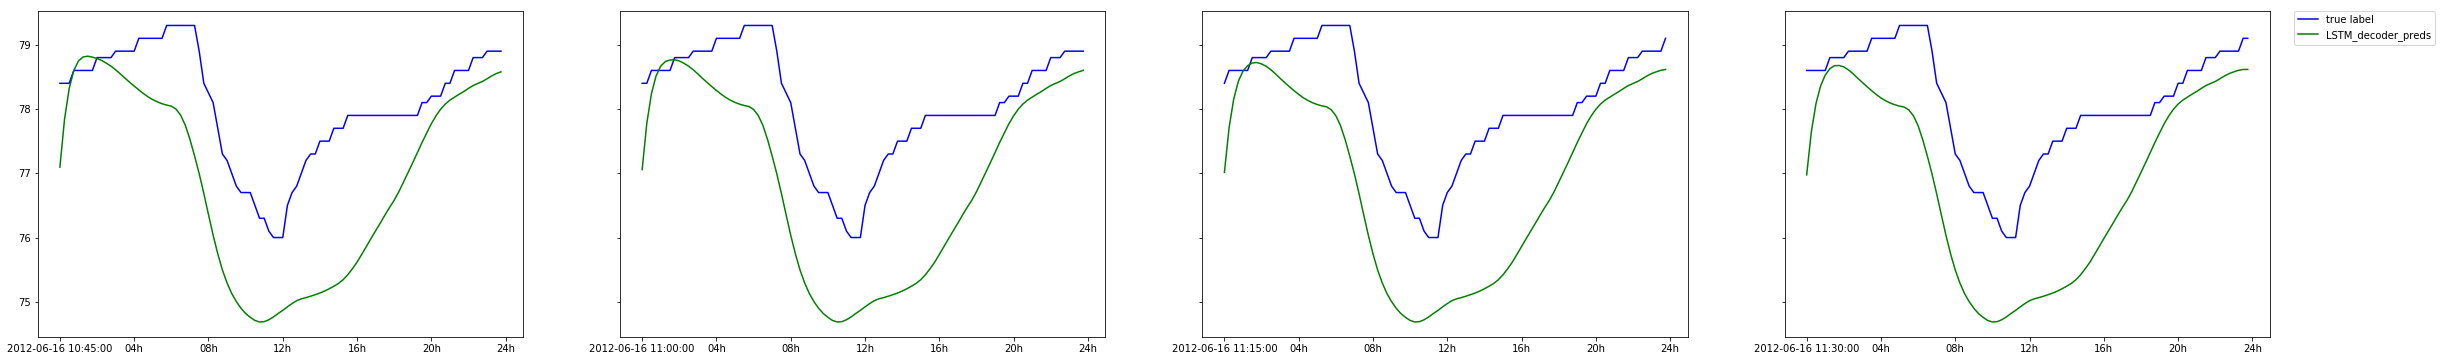

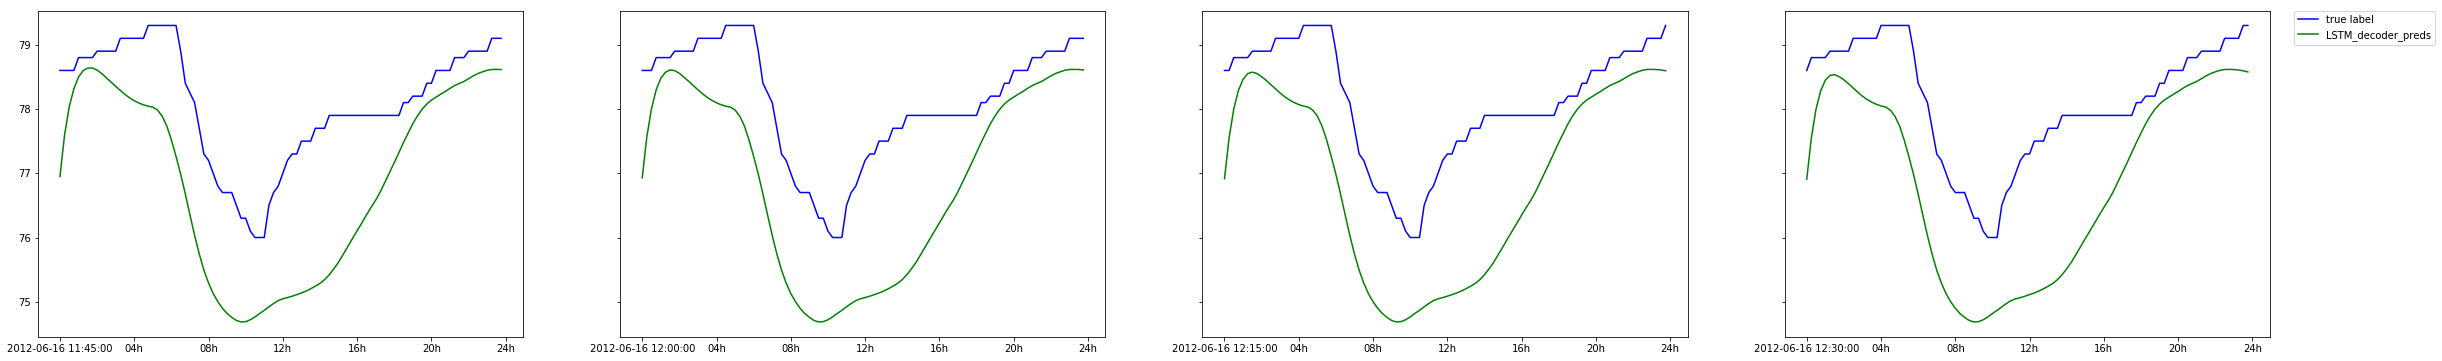

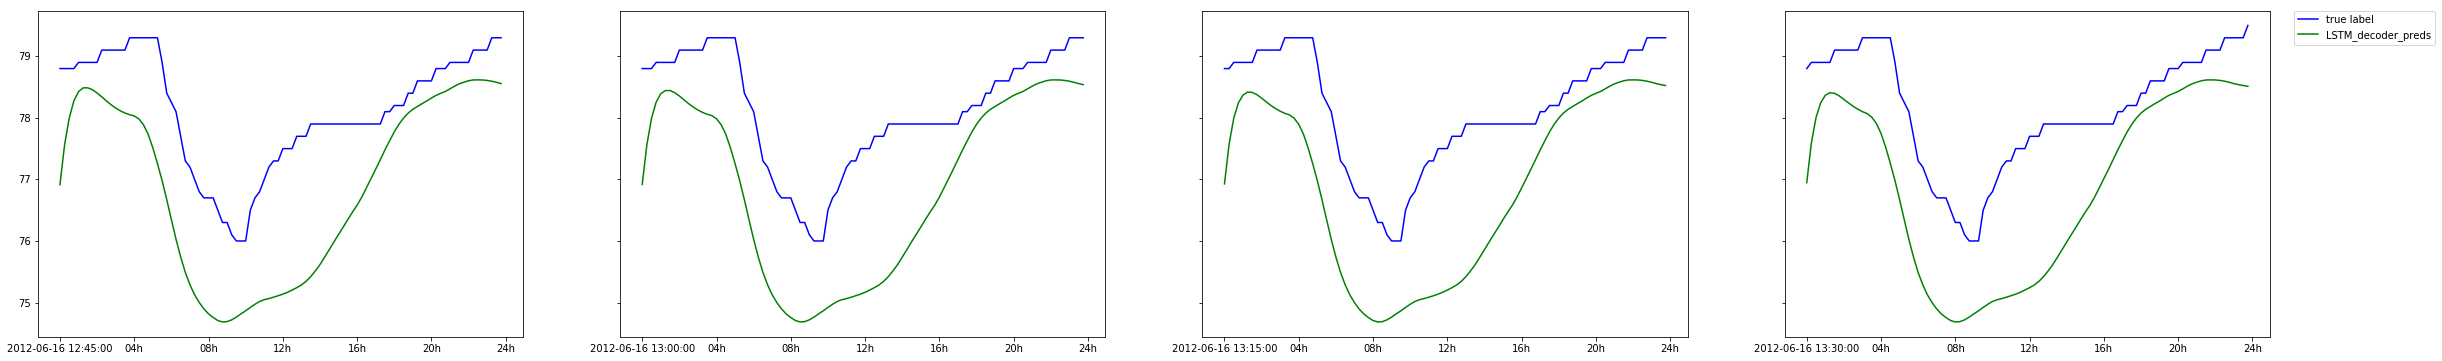

In [16]:
# Forecast 24 hours plot
plot_loops = list(range(7*24*4*4*0, 7*24*4*4*0+4*5))

# Every hours
X_SHOW_FREQUENT = 16
Y_SHOW_FREQUENT = 24 * 7

x_stick = list(range(0, int((Y_preds_decoder.shape[1] + 1) ), X_SHOW_FREQUENT))
y_stick = list(range(0, Y_preds_decoder.shape[0], Y_SHOW_FREQUENT))

time_train[[y_stick_value for y_stick_value in y_stick]]
x_stick_content = np.array([time_train[0],
                           '01h','01h','01h','01h', 
                           '02h','02h','02h','02h',
                           '03h','03h','03h','03h', 
                           '04h','04h','04h','04h',
                           '05h','05h','05h','05h',
                           '06h','06h','06h','06h', 
                           '07h','07h','07h','07h', 
                           '08h','08h','08h','08h',
                           '09h','09h','09h','09h', 
                           '10h','10h','10h','10h', 
                           '11h','11h','11h','11h', 
                           '12h','12h','12h','12h',
                           '13h','13h','13h','13h',
                           '14h','14h','14h','14h', 
                           '15h','15h','15h','15h', 
                           '16h','16h','16h','16h',
                           '17h','17h','17h','17h',
                           '18h','18h','18h','18h', 
                           '19h','19h','19h','19h', 
                           '20h','20h','20h','20h',
                           '21h','21h','21h','21h',
                           '22h','22h','22h','22h', 
                           '23h','23h','23h','23h', 
                           '24h','24h','24h','24h'])
PER_ROW = 4
plot_step = []

print("LSTM Decoder RMSE : ", np.sum((Y_preds_decoder[:, :, :] - Y_test_p[:, :, :]) ** 2) / (Y_test_p.shape[0] * Y_test_p.shape[1]))

# Four axes, returned as a 2-d array
for plot_index in plot_loops:
    plot_step.append(plot_index)
    
    if(plot_index % PER_ROW == PER_ROW - 1):
        if(len(plot_step) == PER_ROW):
            f, axarr = plt.subplots(1, PER_ROW, sharey=True, figsize=(40, 6))
            plt.setp(axarr, xticks=x_stick, xticklabels=x_stick_content)
            #plt.tight_layout()

            for index in plot_step:
                x_stick_content[0] = time_train[index]
                plt.sca(axarr[int(index % PER_ROW)])
                plt.xticks(x_stick, x_stick_content[[x_stick_value for x_stick_value in x_stick]])
                axarr[int(index % PER_ROW)].plot(list(range(96)), Y_test_p[index, :], 'blue', label="true label")
                axarr[int(index % PER_ROW)].plot(list(range(96)), Y_preds_decoder[index, :], 'green', label="LSTM_decoder_preds")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()
            # Fine-tune figure; make subplots farther from each other.
            f.subplots_adjust(hspace=0.2)
            plot_step = []


### Predict Net - Model Training

In [17]:
# Run training
model.compile(optimizer='adam',
              loss={'decoder_output': 'mse', 'prediction_output': 'mse'},
              loss_weights={'decoder_output': 0.0, 'prediction_output': 1.0})

if(is_load_predictnet_best_weight is True):
    model.load_weights(predictnet_weight_filepath)

if(is_train_predictnet is True):
    checkpoint = ModelCheckpoint(predictnet_weight_filepath, monitor='val_prediction_output_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    
    print('Starting training...')
    model.fit([X_train, X2_train], [Y_train, Y_train],
              batch_size=batch_size,
              epochs=predictnet_epochs,
              validation_split=0.2,
              callbacks=callbacks_list)

Starting training...
Train on 59104 samples, validate on 14777 samples
Epoch 1/1
59104/59104 [==============================] - 376s 6ms/step - loss: 0.7935 - decoder_output_loss: 0.5979 - prediction_output_loss: 0.7935 - val_loss: 0.6292 - val_decoder_output_loss: 0.5214 - val_prediction_output_loss: 0.6292

Epoch 00001: val_prediction_output_loss improved from inf to 0.62917, saving model to ./weights/weights_predictnet.best.hdf5


C:\Users\zd2212\AppData\Local\conda\conda\envs\tflatest\lib\site-packages\keras\engine\network.py:888: UserWarning: Layer lstm_7 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_6/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_6/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [36]:
X_test_p_temp = X_test[:,:,:]
X2_test_p_temp = X2_test[:,:,:]
Y_test_p_temp = Y_test[:,:,:]
time_1 = time.time()
Y_preds_temp = model.predict([X_test_p, X2_test_p])
time_2 = time.time()

print(time_2 - time_1)
Y_preds_predictnet = Y_preds_temp[1]

Y_preds_predictnet = scaler.inverse_transform(Y_preds_predictnet)
Y_test_p_temp = scaler.inverse_transform(Y_test_p_temp)

1570.914796113968


In [29]:
Y_preds_predictnet_1 = Y_preds_predictnet

In [31]:
Y_preds_predictnet_2 = Y_preds_predictnet

In [37]:
Y_preds_predictnet_3 = Y_preds_predictnet

In [41]:
sum(sum(Y_preds_predictnet_1 -Y_preds_predictnet_2))

array([1019.8159], dtype=float32)

In [42]:
sum(sum(Y_preds_predictnet_1 -Y_preds_predictnet_3))

array([251.55695], dtype=float32)

In [43]:
sum(sum(Y_preds_predictnet_2 -Y_preds_predictnet_3))

array([-768.25775], dtype=float32)

### Predict Net - Next Step Predition

PredictNet RMSE :  1.0211697704131129
LSTM Decoder RMSE :  1.162550656109182


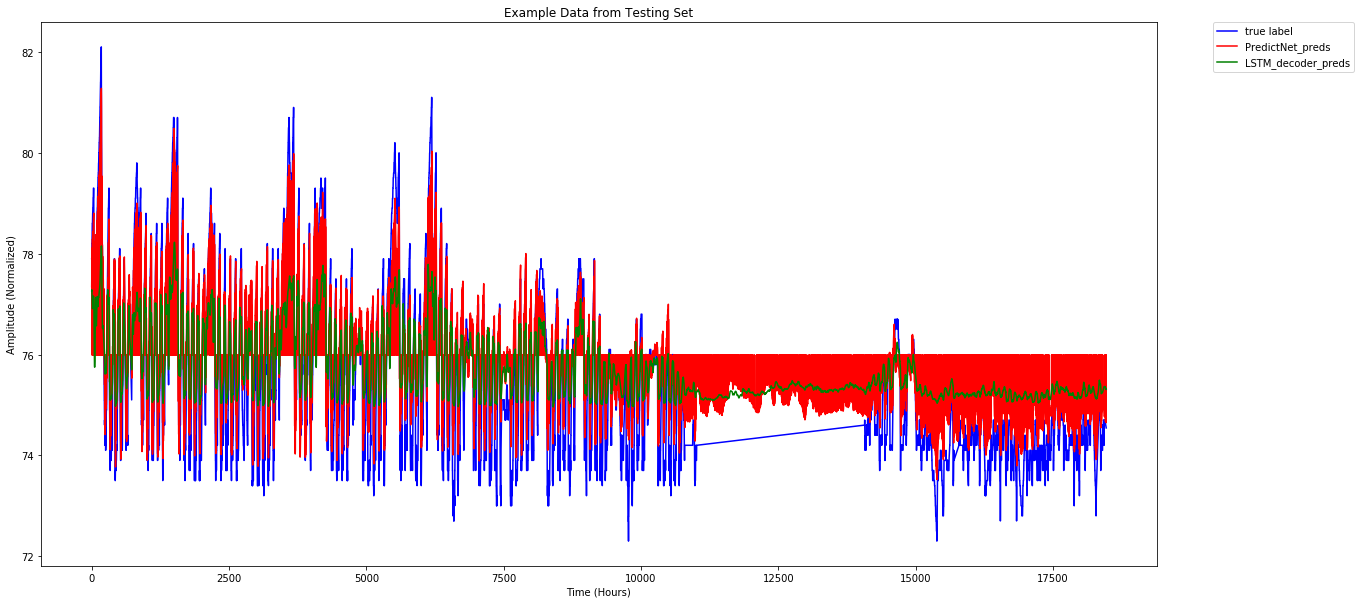

In [22]:
plt.figure(figsize=(20,10))
plt.title('Example Data from Testing Set')

plt.plot(Y_test_p_temp[:, 0, :], 'blue', label="true label")
plt.plot(Y_preds_predictnet[:, 0, :], 'red', label="PredictNet_preds")
plt.plot(Y_preds_decoder[:, 0, :], 'green', label="LSTM_decoder_preds")
plt.xlabel('Time (Hours)')
plt.ylabel('Amplitude (Normalized)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

print("PredictNet RMSE : ", np.sum((Y_preds_predictnet[:, 0, :] - Y_test_p_temp[:, 0, :]) ** 2) / len(Y_test_p_temp[:, 0, :]))
print("LSTM Decoder RMSE : ", np.sum((Y_preds_decoder[:, 0, :] - Y_test_p[:, 0, :]) ** 2) / len(Y_test_p[:, 0, :]))

### Predict Net - Next 24 Hours Predition

LSTM Decoder RMSE :  1.3905845750745982
PredictNet RMSE :  2.002818415760722


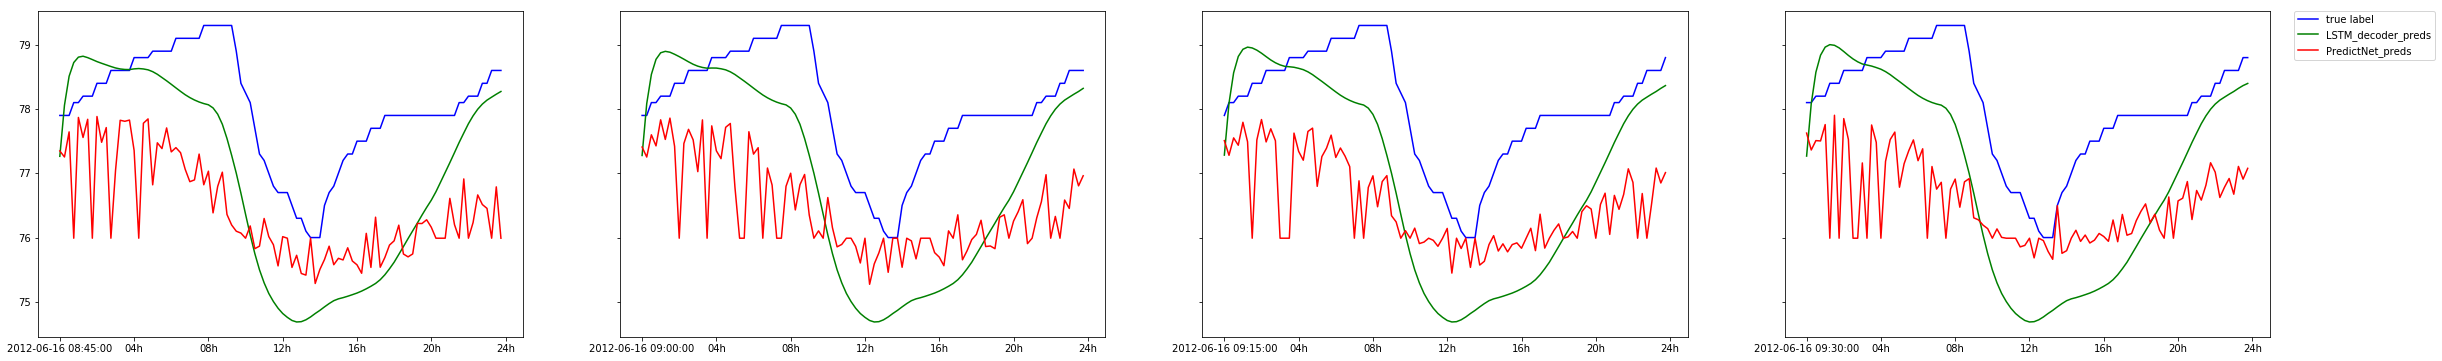

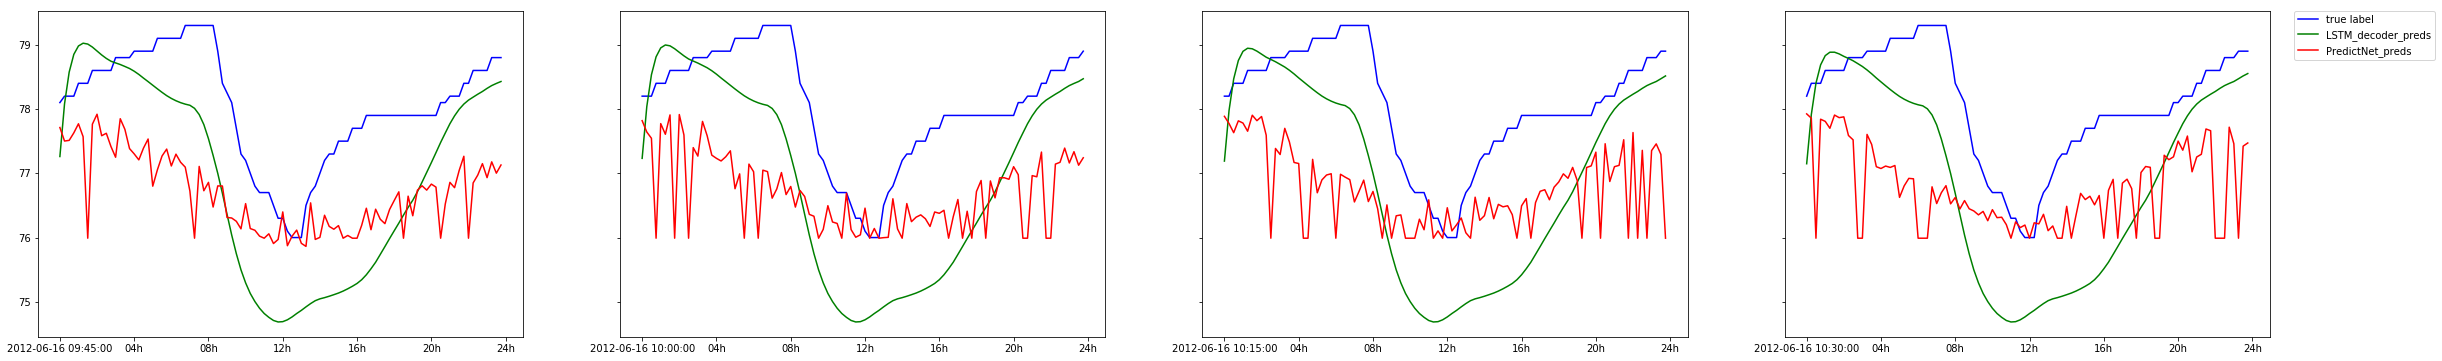

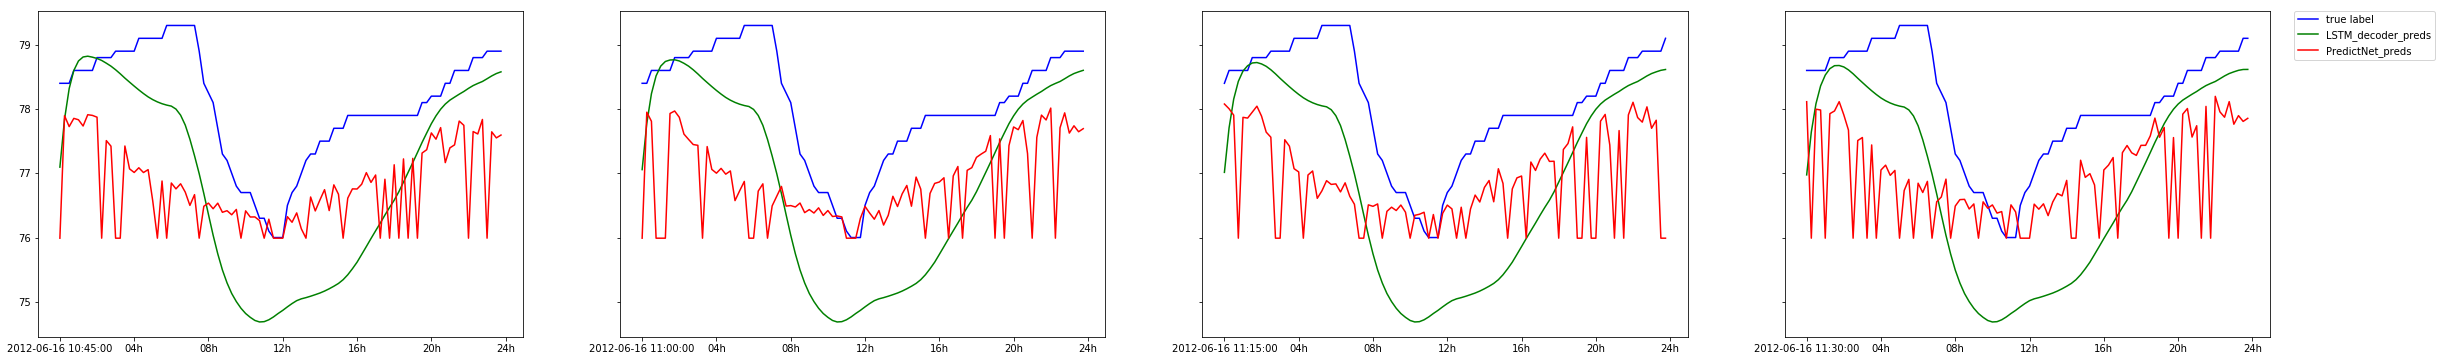

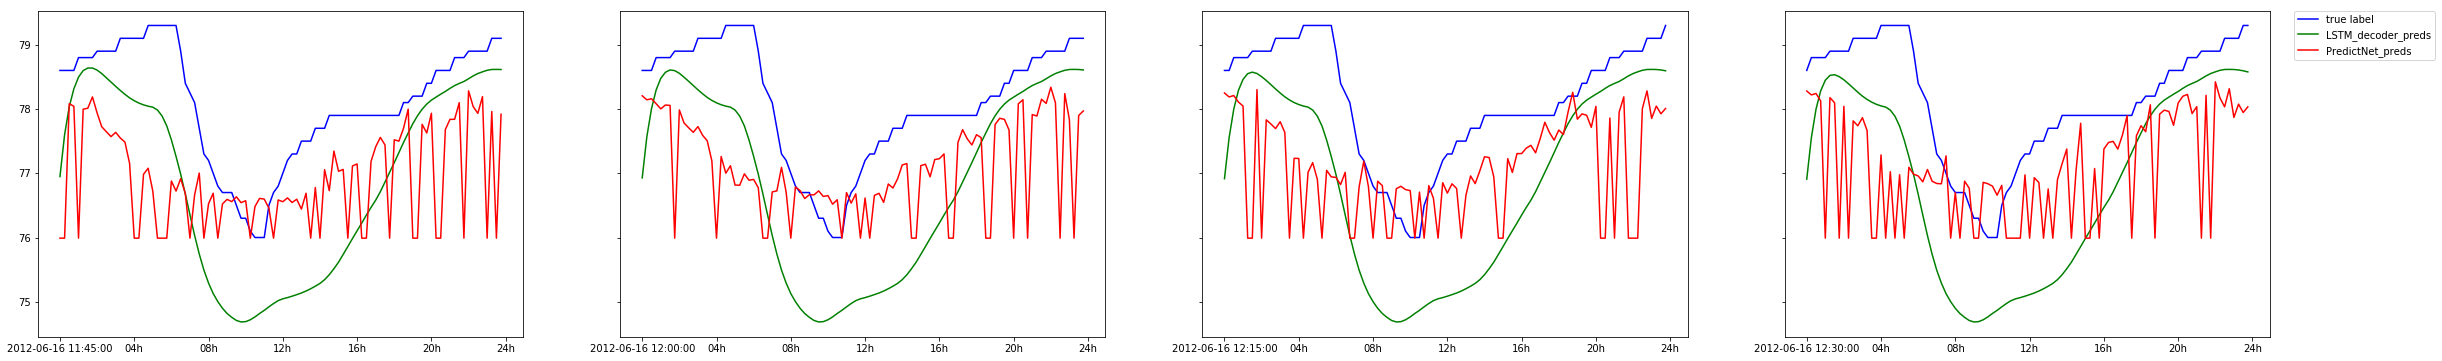

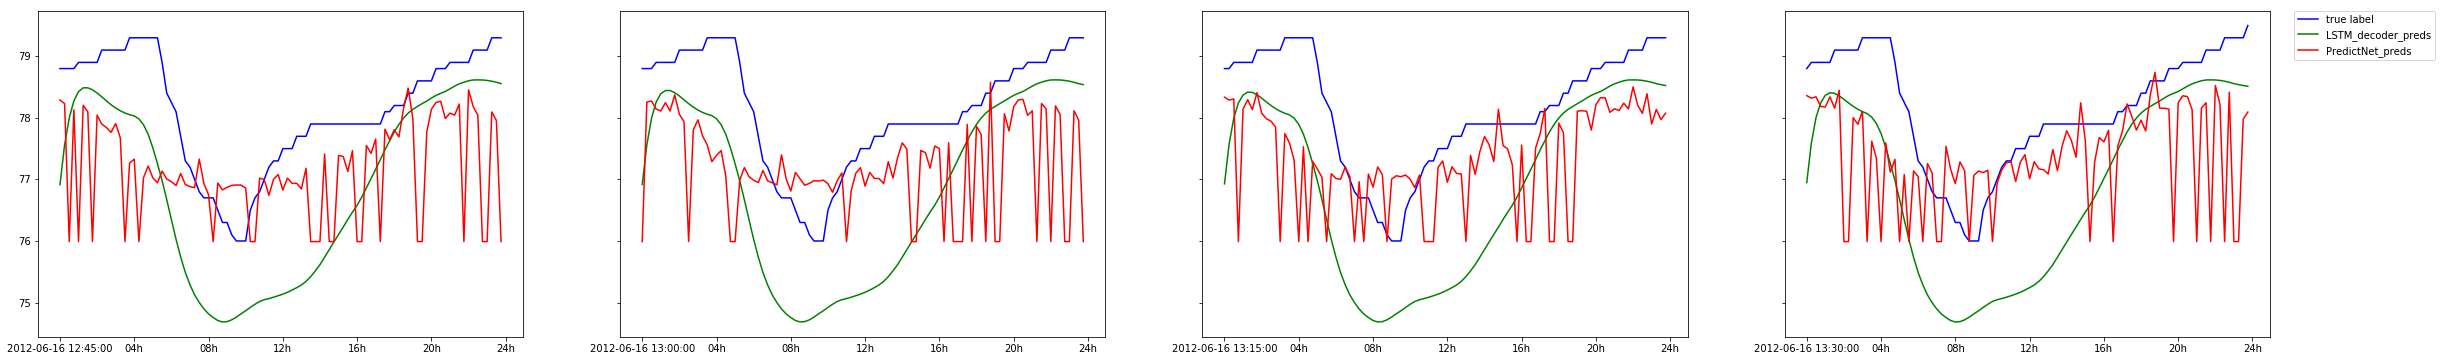

In [23]:
# Forecast 24 hours plot
plot_loops = list(range(7*24*4*4*0, 7*24*4*4*0+4*5))

# Every hours
X_SHOW_FREQUENT = 16
Y_SHOW_FREQUENT = 24 * 7

x_stick = list(range(0, int((Y_preds_decoder.shape[1] + 1) ), X_SHOW_FREQUENT))
y_stick = list(range(0, Y_preds_decoder.shape[0], Y_SHOW_FREQUENT))

time_train[[y_stick_value for y_stick_value in y_stick]]
x_stick_content = np.array([time_train[0],
                           '01h','01h','01h','01h', 
                           '02h','02h','02h','02h',
                           '03h','03h','03h','03h', 
                           '04h','04h','04h','04h',
                           '05h','05h','05h','05h',
                           '06h','06h','06h','06h', 
                           '07h','07h','07h','07h', 
                           '08h','08h','08h','08h',
                           '09h','09h','09h','09h', 
                           '10h','10h','10h','10h', 
                           '11h','11h','11h','11h', 
                           '12h','12h','12h','12h',
                           '13h','13h','13h','13h',
                           '14h','14h','14h','14h', 
                           '15h','15h','15h','15h', 
                           '16h','16h','16h','16h',
                           '17h','17h','17h','17h',
                           '18h','18h','18h','18h', 
                           '19h','19h','19h','19h', 
                           '20h','20h','20h','20h',
                           '21h','21h','21h','21h',
                           '22h','22h','22h','22h', 
                           '23h','23h','23h','23h', 
                           '24h','24h','24h','24h'])
PER_ROW = 4
plot_step = []

print("LSTM Decoder RMSE : ", np.sum((Y_preds_decoder[:, :, :] - Y_test_p[:, :, :]) ** 2) / (Y_test_p.shape[0] * Y_test_p.shape[1]))
print("PredictNet RMSE : ", np.sum((Y_preds_predictnet[:, :, :] - Y_test_p[:, :, :]) ** 2) / (Y_test_p.shape[0] * Y_test_p.shape[1]))

# Four axes, returned as a 2-d array
for plot_index in plot_loops:
    plot_step.append(plot_index)
    
    if(plot_index % PER_ROW == PER_ROW - 1):
        if(len(plot_step) == PER_ROW):
            f, axarr = plt.subplots(1, PER_ROW, sharey=True, figsize=(40, 6))
            plt.setp(axarr, xticks=x_stick, xticklabels=x_stick_content)
            #plt.tight_layout()

            for index in plot_step:
                x_stick_content[0] = time_train[index]
                plt.sca(axarr[int(index % PER_ROW)])
                plt.xticks(x_stick, x_stick_content[[x_stick_value for x_stick_value in x_stick]])
                axarr[int(index % PER_ROW)].plot(list(range(96)), Y_test_p[index, :], 'blue', label="true label")
                axarr[int(index % PER_ROW)].plot(list(range(96)), Y_preds_decoder[index, :], 'green', label="LSTM_decoder_preds")
                axarr[int(index % PER_ROW)].plot(list(range(96)), Y_preds_predictnet[index, :], 'red', label="PredictNet_preds")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()
            # Fine-tune figure; make subplots farther from each other.
            f.subplots_adjust(hspace=0.2)
            plot_step = []


In [28]:
# Clear the session

from keras import backend as K
import gc

K.clear_session()
try:
    del model
except:
    pass
gc.collect()

1516

In [29]:
def cog_clear():
    K.clear_session()
    try:
        del model
    except:
        pass
    gc.collect()

## Baseline Model

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Input, concatenate, Lambda, Reshape, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

# Define an input sequence and process it.
encoder_inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
decoder_inputs = Input(shape=(X2_train.shape[1], X_train.shape[2]))
encoder = LSTM(128, return_sequences = True)(encoder_inputs)
encoder = Dropout(0.2)(encoder)
encoder = LSTM(128, return_sequences = True)(encoder)
encoder = Dropout(0.2)(encoder)
encoder = LSTM(Y_train.shape[2], return_sequences = True)(encoder)
encoder = Lambda(lambda a: a[:, -Y_train.shape[1]:, :], output_shape=(Y_train.shape[1], Y_train.shape[2]))(encoder)

model = Model([encoder_inputs], [encoder])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 672, 7)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 672, 128)          69632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 672, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 672, 128)          131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 672, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 672, 1)            520       
_________________________________________________________________
lambda_1 (Lambda)            (None, 96, 1)             0         
Total para

In [ ]:
# Run training
model.compile(optimizer='adam',
              loss='mse')

if(is_load_baseline_lstm_best_weight is True):
    model.load_weights(baseline_lstm_filepath)

if(is_train_baseline_lstm is True):
    checkpoint = ModelCheckpoint(baseline_lstm_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    callbacks_list = [checkpoint]
    
    print('Starting Baseline Training...')
    model.fit([X_train], [Y_train],
              batch_size=batch_size,
              epochs=baseline_lstm_epochs,
              validation_split=0.2,
              callbacks=callbacks_list)

Starting Baseline Training...
Train on 59104 samples, validate on 14777 samples
Epoch 1/50
59104/59104 [==============================] - 1824s - loss: 0.6070 - val_loss: 0.5122
Epoch 2/50
59104/59104 [==============================] - 1806s - loss: 0.4766 - val_loss: 0.6109
Epoch 3/50
59104/59104 [==============================] - 1803s - loss: 0.4193 - val_loss: 0.6317
Epoch 4/50
59104/59104 [==============================] - 1798s - loss: 0.3835 - val_loss: 0.6193
Epoch 5/50
59104/59104 [==============================] - 1814s - loss: 0.3390 - val_loss: 0.6338
Epoch 6/50
59104/59104 [==============================] - 1810s - loss: 0.3230 - val_loss: 0.6276
Epoch 7/50
59104/59104 [==============================] - 1810s - loss: 0.3080 - val_loss: 0.6563
Epoch 8/50
59104/59104 [==============================] - 1805s - loss: 0.3134 - val_loss: 0.6516
Epoch 9/50
59104/59104 [==============================] - 1810s - loss: 0.2997 - val_loss: 0.6418
Epoch 10/50
59104/59104 [=============

In [ ]:
X_test_p = X_test[::24,:,:]
X2_test_p = X2_test[::24,:,:]
Y_test_p = Y_test[::24,:,:]

Y_preds = model.predict([X_test_p])

Y_preds = Y_preds.reshape((Y_preds.shape[0] * Y_preds.shape[1],-1))
Y_test_p = Y_test_p.reshape((Y_preds.shape[0] * Y_preds.shape[1],-1))
Y_test_p = scaler.inverse_transform(Y_test_p)
Y_preds = scaler.inverse_transform(Y_preds)

print("RMSE : ", np.sum((Y_preds - Y_test_p) ** 2) / len(Y_test_p))

plt.figure(figsize=(12,8))
plt.title('Baseline LSTM Model Predictions vs Actual Data')
plt.plot(Y_test_p, 'red', label='true label')
plt.plot(Y_preds, 'blue', label='prediction label')
plt.xlabel('Time (Hours)')
plt.ylabel('Amplitude (Normalized)')
plt.legend(['Actual','Predicted'], loc='upper left')

# 2. Single-Step Predictions

@ Add dual step